-------
Настраиваем окружение

In [ ]:
# Подгружаем фалы утилит

!mkdir utilities

!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/notebooks/src/utils.py -O /content/utilities/utils.py
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/notebooks/src/__init__.py -O /content/utilities/__init__.py

import sys
sys.path.append('/content/utilities')

!pip install seaborn -q
!pip install catboost -q
!pip install lightgbm -q
!pip install xgboost -q
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.3 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

import utilities.utils as utils

import warnings; warnings.filterwarnings("ignore")

----

Загрузка данных

Загрузка данных производиться прям с сервера.

Иногда бывает проблемы с сервером и он выдает отказ.

По этой причине разнёс загрузку по разным ячейкам что бы можно было перезапускать отдельно

In [ ]:
# Загрузка тренировочных данных
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
train = pd.read_csv(url)

In [ ]:
# Загрузка тестовых данных
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'
test = pd.read_csv(url)

In [ ]:
# Оптимизируем данные

print('Optimization train')
train = utils.reduce_mem_usage(train)
print('Optimization test')
test = utils.reduce_mem_usage(test)

Optimization train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.15 MB
Decreased by 50.0%
Optimization test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.12 MB
Decreased by 48.4%


-----

Общее исследование данных

In [ ]:
# Общая информация по обучающим данным
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    2337 non-null   object 
 1   model                     2337 non-null   object 
 2   car_type                  2337 non-null   object 
 3   fuel_type                 2337 non-null   object 
 4   car_rating                2337 non-null   float16
 5   year_to_start             2337 non-null   int16  
 6   riders                    2337 non-null   int32  
 7   year_to_work              2337 non-null   int16  
 8   target_reg                2337 non-null   float16
 9   target_class              2337 non-null   object 
 10  mean_rating               2337 non-null   float16
 11  distance_sum              2337 non-null   float32
 12  rating_min                2337 non-null   float16
 13  speed_max                 2337 non-null   float16
 14  user_rid

In [ ]:
# Информация о количесве уникальных значений в обучающих данных
train.apply('nunique')

car_id                      2337
model                         26
car_type                       4
fuel_type                      2
car_rating                   269
year_to_start                  7
riders                      2306
year_to_work                   9
target_reg                  1341
target_class                   9
mean_rating                  479
distance_sum                2337
rating_min                    91
speed_max                    763
user_ride_quality_median    2108
deviation_normal_count         1
user_uniq                     30
dtype: int64

In [ ]:
# Общая информация по тестовым данным
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   car_id                    1913 non-null   object 
 1   model                     1913 non-null   object 
 2   car_type                  1913 non-null   object 
 3   fuel_type                 1913 non-null   object 
 4   car_rating                1913 non-null   float16
 5   year_to_start             1913 non-null   int16  
 6   riders                    1913 non-null   int32  
 7   year_to_work              1913 non-null   int16  
 8   target_class              1913 non-null   object 
 9   mean_rating               1913 non-null   float16
 10  distance_sum              1913 non-null   float32
 11  rating_min                1913 non-null   float16
 12  speed_max                 1913 non-null   float16
 13  user_ride_quality_median  1913 non-null   float16
 14  deviatio

In [ ]:
# Информация о количесве уникальных значений в тестовых данных
test.apply('nunique')

car_id                      1913
model                         26
car_type                       4
fuel_type                      2
car_rating                   252
year_to_start                  7
riders                      1894
year_to_work                   9
target_class                   8
mean_rating                  466
distance_sum                1912
rating_min                    90
speed_max                    729
user_ride_quality_median    1731
deviation_normal_count         1
user_uniq                     31
dtype: int64

Первый момент который хочеться заметить из общего анализа данных.

Пропущенных значений нет.

Первое что бросатеться в глаза это одно значение в поле deviation_normal_count


In [ ]:
# Проверяем что за одно такое значение в трайне и тесте
print(f"значенеи в колонке deviation_normal_count в обучающих данных = {train['deviation_normal_count'][0]}")
print(f"значенеи в колонке deviation_normal_count в тестовых данных  = {test['deviation_normal_count'][0]}")

значенеи в колонке deviation_normal_count в обучающих данных = 174
значенеи в колонке deviation_normal_count в тестовых данных  = 174


Колонка deviation_normal_count в обоих наборах имеет одинаковое значение и не несет дополнительной информации на данный момент.

Интересно помотреть на распределение данных между обучающим и тестовым датасетом

In [ ]:
# создаемп удобную функцию для отображения

def Show_hist(column = "distance_sum", n_buns = 100):
  tmp_df_1 = train[column].to_frame(name = column)
  tmp_df_1['type'] = 'TRAIN'

  tmp_df_2 = test[column].to_frame(name = column)
  tmp_df_2['type'] = 'TEST'

  tmp_df_3 = pd.concat([tmp_df_1, tmp_df_2])

  g = sns.displot(
    data=tmp_df_3,
    x=column,
    hue="type",
    legend=True,
    aspect=1,
    kind="hist",
    alpha=0.5,
    bins= n_buns
  );

  del tmp_df_1, tmp_df_2, tmp_df_3

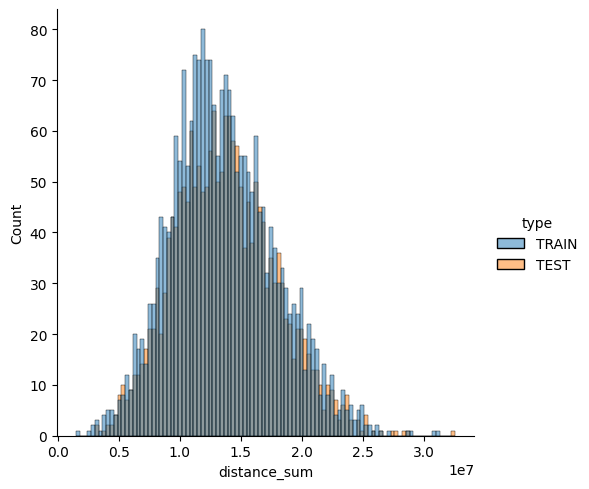

In [ ]:
Show_hist(column = "distance_sum", n_buns = 100)

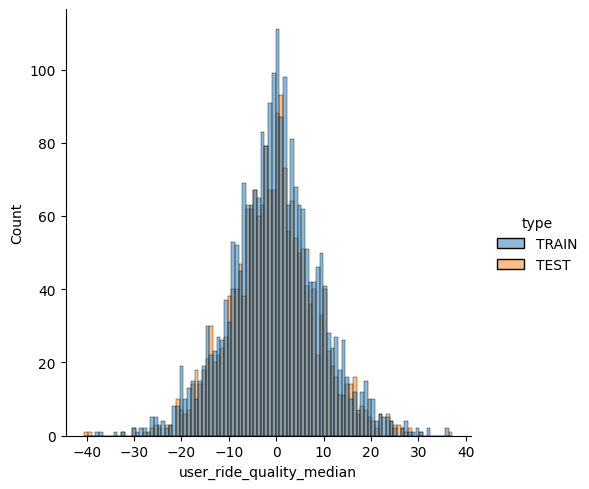

In [ ]:
Show_hist(column = "user_ride_quality_median", n_buns = 100)

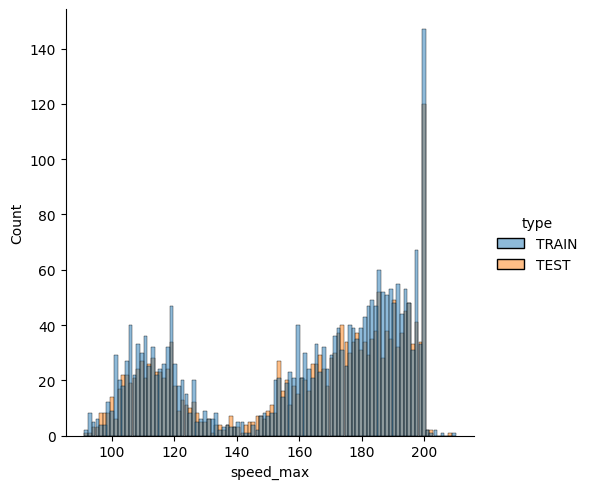

In [ ]:
Show_hist(column = "speed_max", n_buns = 100)

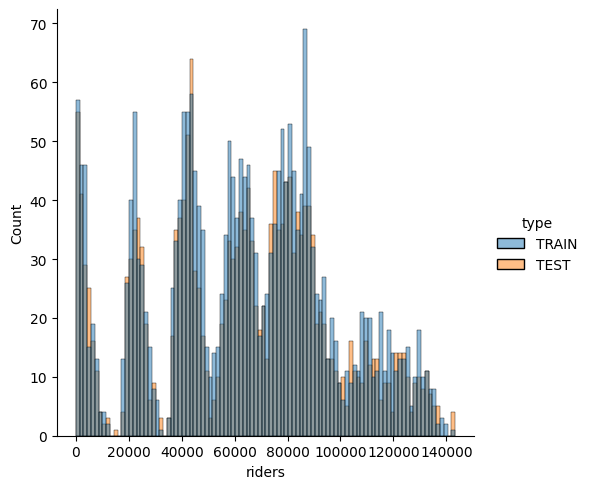

In [ ]:
Show_hist(column = "riders", n_buns = 100)

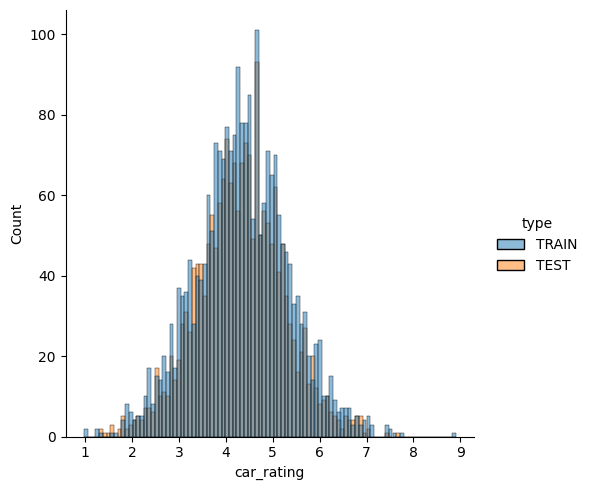

In [ ]:
Show_hist(column = "car_rating", n_buns = 100)

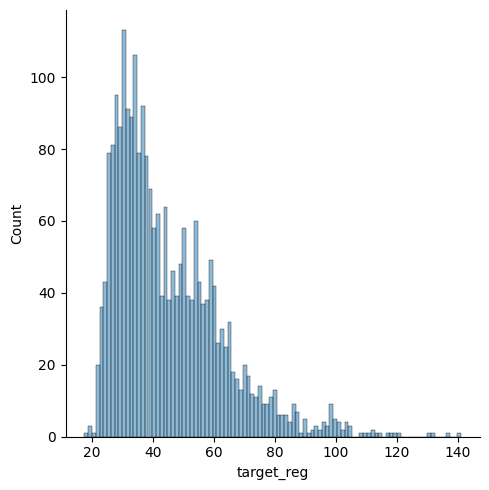

In [ ]:
# построим распределение для целевой переменой
g = sns.displot(
    data=train,
    x="target_reg",
    legend=True,
    aspect=1,
    kind="hist",
    alpha=0.5,
    bins= 100
  );

Из преведенных выше графиков можно сделать первоначальный вывод что без учета распределения по группам заметной разница между обучающей выборкой и тестовой особо нет. Можно предположить что локальная валедация будет хорошо работать и корелировать с лидербордом.

Целевая переменная имеет правую ассимитрию.

Как возможная идея: возможно придеться привести целевую величину к нормальному виду.

Небольшая заметка: были просмотренны все граффики, вывел не все что бы не загромождать.

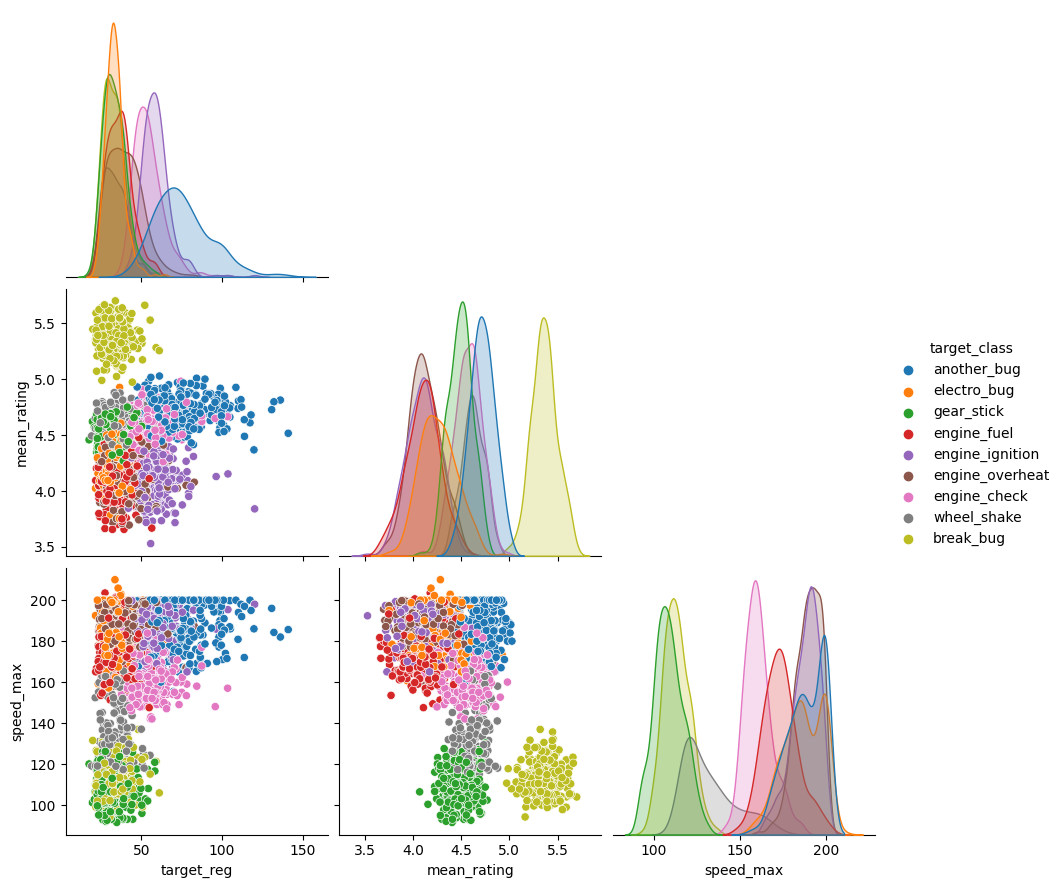

In [ ]:
# Построим диаграмму рассеяния для обучающих данных
sns.pairplot(
    train,
    vars=["target_reg", "mean_rating", "speed_max"],
    corner = True,
    hue="target_class",
    height = 3
);

На диаграмме оставил только самые интересные графики.

Видно что параметры "mean_rating", "speed_max" имеют не такие сплошние перекрывающтеся расеенья и очень хорошо отделяют один класс.

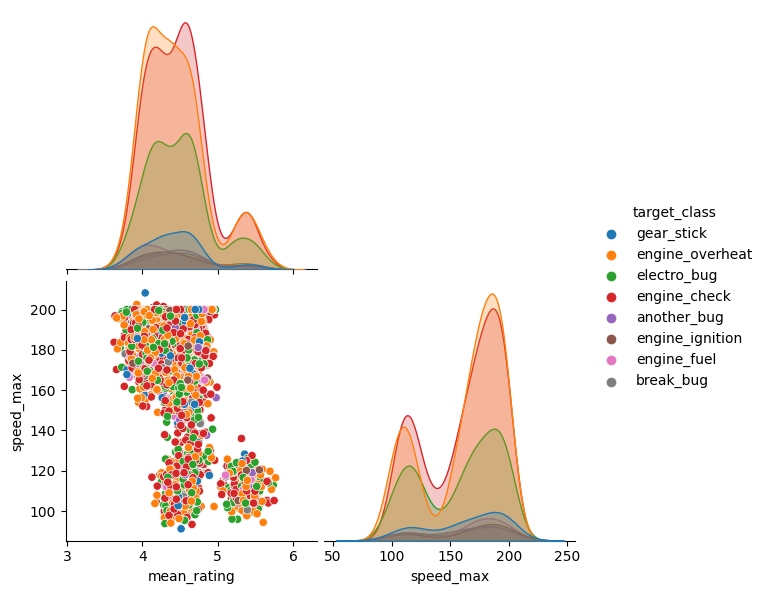

In [ ]:
# Построим диаграмму рассеяния для тестовых данных но уже без целевой переменной с учетом информации о оссобеностях "mean_rating", "speed_max"
sns.pairplot(
    test,
    vars=["mean_rating", "speed_max"],
    corner = True,
    hue="target_class",
    height = 3
);

Был замечен интересный момент в тестовых данных.

Метки вида поломок в тестовых данных перемешанны. Данный вывод можно сделать из того что признаки "mean_rating", "speed_max" в обучающих данных формируют отдельный кластер и харрактерное распределение с поломками. В тестовых данных мы видим характерный кластер но его метки не соответвуют.

Далее испольpование меток класса поломок будет больше для крассоты и наглядности но операться на него для прогназирования я конечно же не буду.


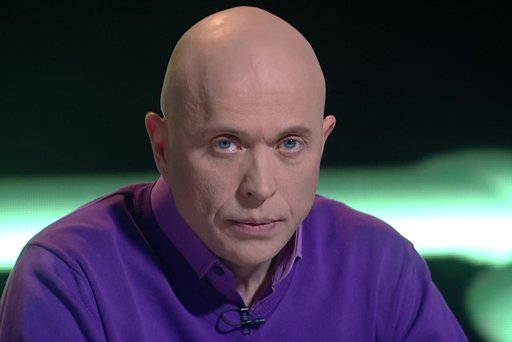

Посмотрим на котегариальные данные

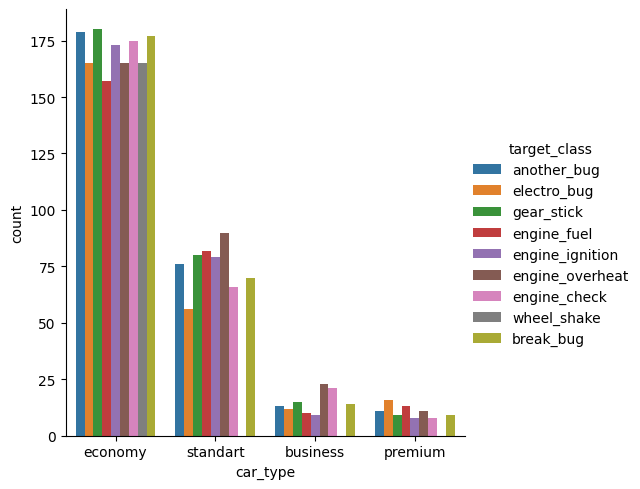

In [ ]:
# Посмотрим на как распределены данные по категирии классу автомабиля на обучающих данных
sns.catplot(
    data=train,
    x="car_type",
    hue="target_class",
    kind="count");

Саммый популярный класс эконом и только по нему есть данные о проблемах с колесами.

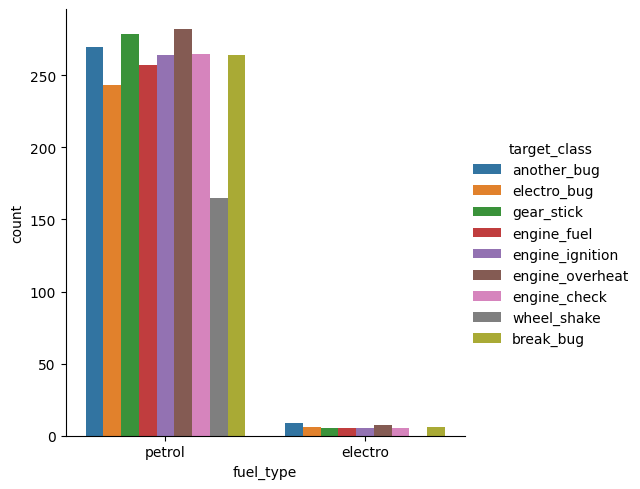

In [ ]:
# Посмотрим на как распределены данные по категирии классу автомабиля на обучающих данных
sns.catplot(
    data=train,
    x="fuel_type",
    hue="target_class",
    kind="count");

Саммый популярный класс бензиновый и только по нему есть данные о проблемах с колесами.

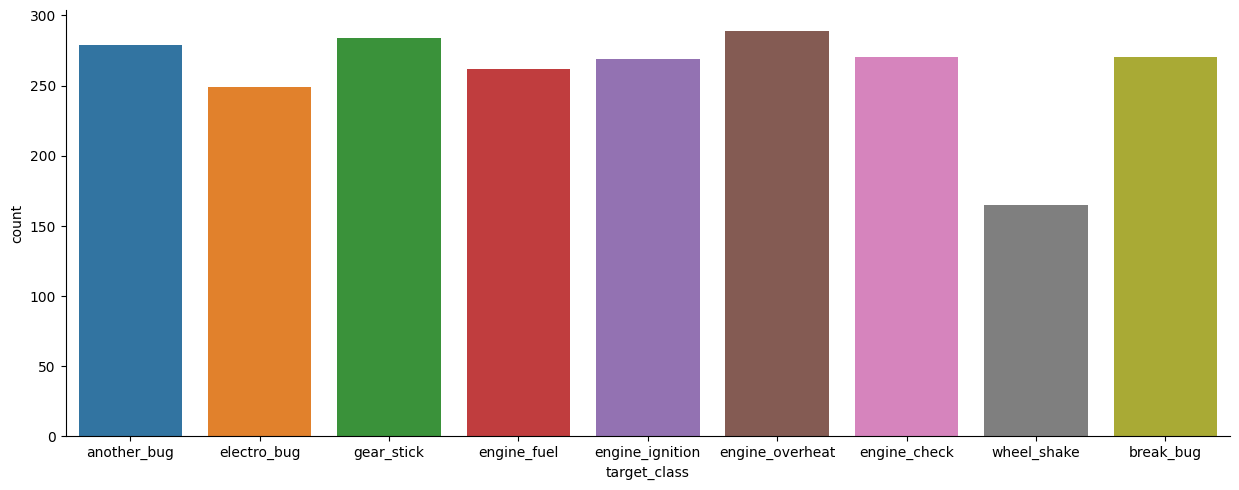

In [ ]:
# Посмотрим на как распределены данные по категирии тип поломки на обучающих данных
sns.catplot(
    data=train,
    x="target_class",
    kind="count",
    aspect=2.5);

Стоит посмотреть распределение категориальных данных на тестовых данных из за сюрприза обнаруженном ранее

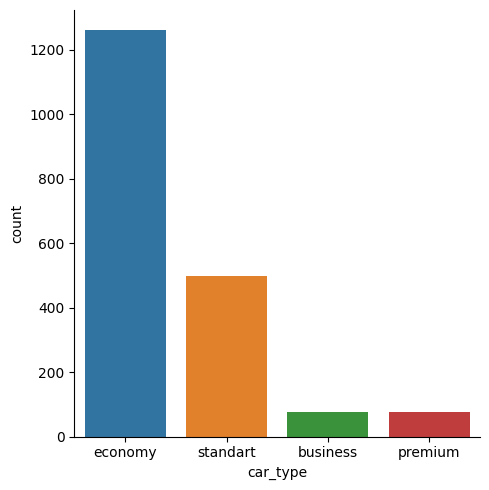

In [ ]:
# Посмотрим на как распределены данные по категирии классу автомабиля на тестовых данных
sns.catplot(
    data=test,
    x="car_type",
    kind="count");

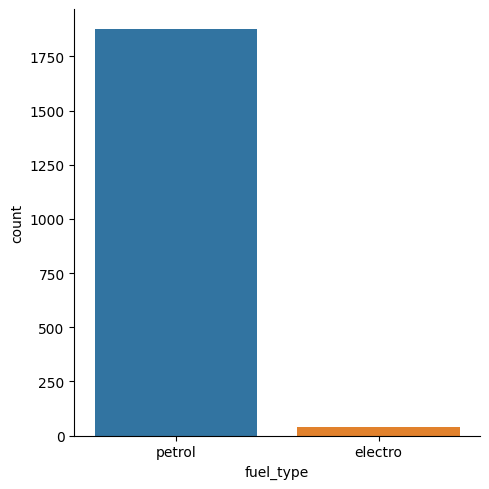

In [ ]:
# Посмотрим на как распределены данные по категирии классу автомабиля на тестовых данных
sns.catplot(
    data=test,
    x="fuel_type",
    kind="count");

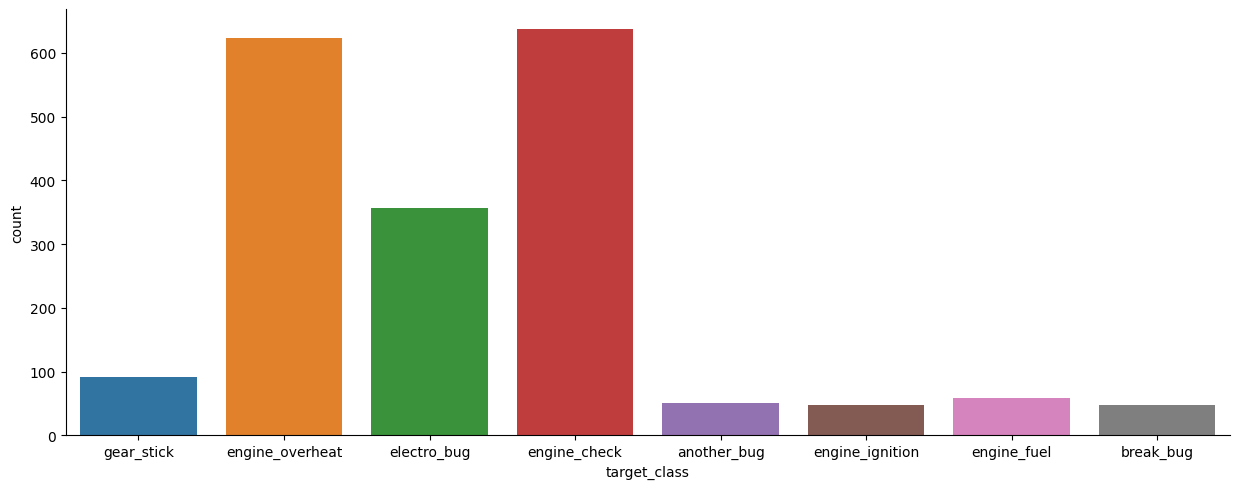

In [ ]:
# Посмотрим на как распределены данные по категирии тип поломки на тестовых данных
sns.catplot(
    data=test,
    x="target_class",
    kind="count",
    aspect=2.5);

В итогу можно сказать что по категориальным признакам также распределение соотносяться за исключением "target_class" в тестовых данных.

"target_class" необходимо будет исключть из выборки

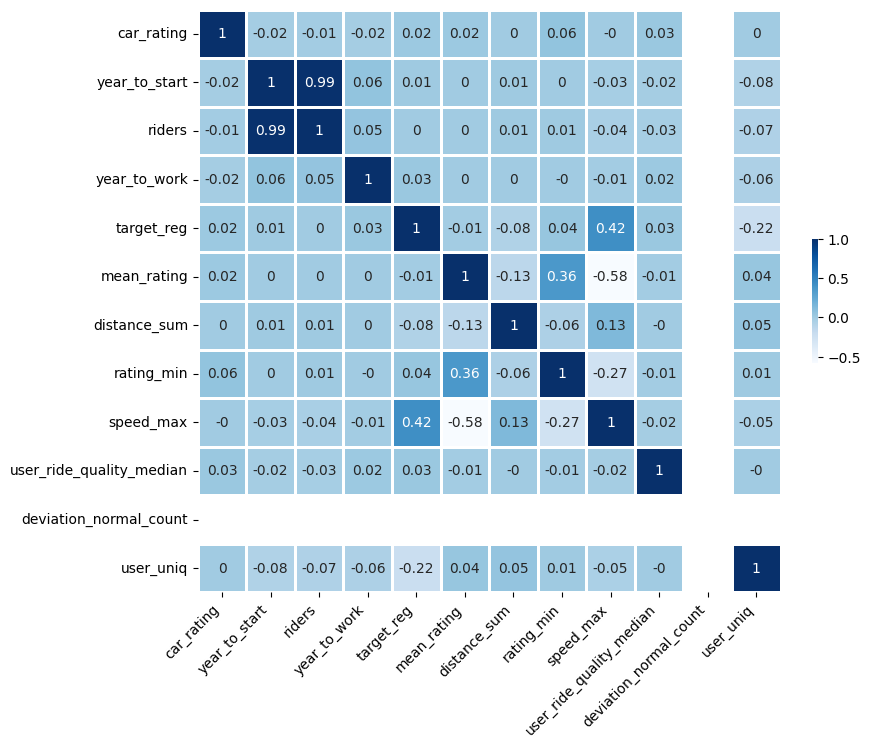

In [ ]:
# На последок взглянем на корреляцию по переменным
plt.rcParams["figure.figsize"] = (8, 8)

heatmap = sns.heatmap(
    train.corr(numeric_only = True).round(2),
    annot=True,
    square=True,

    cmap="Blues",  # использовать синию цветовую карту
    cbar_kws={"fraction": 0.01},  # боковой колор-бар (shrink colour bar)
    linewidth=2  # пространство между клетками
);

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
);

Из преведенной матрецы корреляций можно сделать вывод что есть небольшая положительная ленейная зависимость "target_reg" и "speed_max" и небольшая отрицательная зависимость от количесва уникальных пользователей.

Также есть зависимости между признаками вызванные самой природой данных признаков. Пример чем раньше автомобиль вышел на работу темь больше у него будет поездок. Чем выше максимальная скорость тем ниже средний рейтинг.

Однако с данной интерпритацией надо быть осторожным что бы не получить мнимые выводы.
Как например: Чем больше количесво пожарных на пожаре тем выше класс пожара. Неправельный вывод - уменьшаем количесво пожарных для снижения класса пожара)))

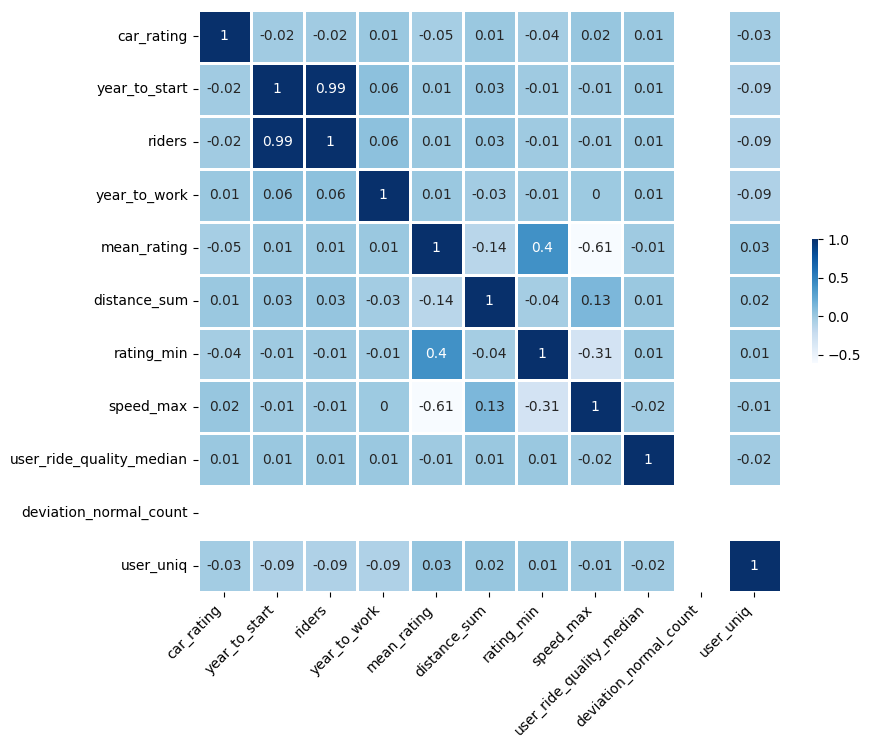

In [ ]:
# Учитывая подставу с "target_class" в тестовых данных стоит взглянуть на корреляции и в тестовой выборке
plt.rcParams["figure.figsize"] = (8, 8)

heatmap = sns.heatmap(
    test.corr(numeric_only = True).round(2),
    annot=True,
    square=True,

    cmap="Blues",  # использовать синию цветовую карту
    cbar_kws={"fraction": 0.01},  # боковой колор-бар (shrink colour bar)
    linewidth=2  # пространство между клетками
);

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
);

В тестовой выборке корреляции также похожи как и в обучающей

Итог по анализу данных:
Тренеровочный набор и тестовый набор похожи, но были сюрпризы.
Необходимо будет исключить два признака "deviation_normal_count", "target_class".
Было обнаружене несколько признаков которые на первый взгляд имеют потенциал и чтоит к ним присмотреться.

In [ ]:
train.drop(columns=['deviation_normal_count', 'target_class', 'car_id'], inplace = True)

data_dic = {'car_id' : test['car_id']}
tmp_sub = pd.DataFrame(data=data_dic)

test.drop(columns=['deviation_normal_count', 'target_class', 'car_id'], inplace = True)

In [ ]:
# Сформируем удобные преременные которые нам прегодяться
cat_features = ['model', 'car_type', 'fuel_type']
targets = ['target_reg']

---------------------------------

Работа с моделями

In [ ]:
# Глобальные переменные для моделей
list_best_models = []

# Разбиение данных на фолды
n_splits = 3  # Число фолдов.

# параметры валидации, обучение будет идти на n_splits фолдах
X = train.drop(columns=targets, errors='ignore')
y = train['target_reg']

# Для различных тестов
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Закодируем категариальные переменные (для тех кто не умеет работать с категориями)
# в One Hot Encode т.к. порядка в виде последовательности нет
X_CatCoded = X.copy(deep = True)
for col in cat_features:
  one_hot = pd.get_dummies(X_CatCoded[col], prefix = col)
  X_CatCoded = X_CatCoded.drop(col,axis = 1)
  X_CatCoded = X_CatCoded.join(one_hot)

test_CatCoded = test.copy(deep = True)
for col in cat_features:
  one_hot = pd.get_dummies(test_CatCoded[col], prefix = col)
  test_CatCoded = test_CatCoded.drop(col,axis = 1)
  test_CatCoded = test_CatCoded.join(one_hot)

X_train_all_CatCoded, X_test_all_CatCoded = X_CatCoded.iloc[X_train_all.index], X_CatCoded.iloc[X_test_all.index]

Обучаем CatBoost

In [ ]:
# Попробуем примерно узнать обтемальные гипер параметры

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_features,
    eval_metric="RMSE",
    verbose=False,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}

# Внутри самой функции данные помещяються в Pool и особо нет смысла их помещять снаружи
randomized_search_result = model.randomized_search(param_distribution, X_train_all, y_train_all)
print(f'Best paremetr = {randomized_search_result["params"]}')


bestTest = 11.7048528
bestIteration = 966

0:	loss: 11.7048528	best: 11.7048528 (0)	total: 1.23s	remaining: 11s

bestTest = 10.84032022
bestIteration = 999

1:	loss: 10.8403202	best: 10.8403202 (1)	total: 4.25s	remaining: 17s

bestTest = 10.67623405
bestIteration = 919

2:	loss: 10.6762340	best: 10.6762340 (2)	total: 6.31s	remaining: 14.7s

bestTest = 11.63872369
bestIteration = 687

3:	loss: 11.6387237	best: 10.6762340 (2)	total: 6.88s	remaining: 10.3s

bestTest = 16.43367042
bestIteration = 137

4:	loss: 16.4336704	best: 10.6762340 (2)	total: 7.15s	remaining: 7.15s

bestTest = 16.43366952
bestIteration = 39

5:	loss: 16.4336695	best: 10.6762340 (2)	total: 7.42s	remaining: 4.95s

bestTest = 10.75206261
bestIteration = 401

6:	loss: 10.7520626	best: 10.6762340 (2)	total: 8.88s	remaining: 3.81s

bestTest = 11.65731637
bestIteration = 768

7:	loss: 11.6573164	best: 10.6762340 (2)	total: 9.46s	remaining: 2.36s

bestTest = 10.92035302
bestIteration = 469

8:	loss: 10.9203530	best: 10.6762

In [ ]:
# Взглянем как модель оценит признаки
train_pool = Pool(X_train_all, y_train_all, cat_features=cat_features)
test_pool = Pool(X_test_all, y_test_all, cat_features=cat_features)

model = CatBoostRegressor(iterations=1000, random_seed=42)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-12',
    num_features_to_select=6,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    train_final_model=True,
    logging_level='Silent',
    plot=False
)

# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

The number of features selection steps (10) is greater than the number of features to eliminate (7). The number of steps was reduced to 7.


['car_type', 'fuel_type', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max']
Best loss: 12.233806633587205


In [ ]:
# Посмотрим на важность признаков
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,39.140147
1,mean_rating,34.253689
2,rating_min,16.560853
3,car_type,4.432169
4,fuel_type,3.859683
5,distance_sum,1.753459
6,model,0.000000
7,car_rating,0.000000
8,year_to_start,0.000000
9,riders,0.000000


Результат оценки признаков соотноситься с теми выводами что мы делали при первичном анализе. В частности с корреляционным.

In [ ]:
# Обучем итогувую модель CatBoost
cat_boost_model = [] # Тут будем сохранять модели CatBoost
cat_boost_scores = [] # Тут будем хранить скоры валидационных фолдов CatBoost
cat_boost_best_score = 99999
cat_boost_best_model = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for step, (train_index, test_index) in enumerate(kf.split(X), start=1):

    print('-'*80)
    print(f'Start step CatBoost -> {step}')

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostRegressor(
        random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE",
        l2_leaf_reg = 5, depth = 4.0, one_hot_max_size = 2.0, learning_rate = 0.3, iterations = 2000
        )

    cat_boost_model.append(model)

    model.fit(
      train_pool,
      eval_set=test_pool,
      verbose=100,
      use_best_model=True,
      plot=False,
      early_stopping_rounds=100
      )

    if cat_boost_best_score > model.best_score_['validation']['RMSE']:
      cat_boost_best_score = model.best_score_['validation']['RMSE']
      cat_boost_best_model = model

    cat_boost_scores.append(model.best_score_['validation']['RMSE'])
    print('-'*80)

list_best_models.append(cat_boost_best_model)

--------------------------------------------------------------------------------
Start step CatBoost -> 1
0:	learn: 15.9260831	test: 15.5486669	best: 15.5486669 (0)	total: 2.28ms	remaining: 4.56s
100:	learn: 9.1019536	test: 12.3132244	best: 12.0845626 (28)	total: 189ms	remaining: 3.54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.08456258
bestIteration = 28

Shrink model to first 29 iterations.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start step CatBoost -> 2
0:	learn: 15.2062048	test: 16.2107013	best: 16.2107013 (0)	total: 1.99ms	remaining: 3.99s
100:	learn: 9.3098272	test: 12.0192762	best: 11.8937008 (50)	total: 176ms	remaining: 3.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 11.89370085
bestIteration = 50

Shrink model to first 51 iterations.
--------------------------------------------------------------------------

In [ ]:
tmp_sub['cat_boost_pred'] = cat_boost_best_model.predict(test)

In [ ]:
# Своя функция потерь для GridSearch
def my_costom_rmse_for_GS_CV(y_true, y_pred):
  return np.sqrt(np.mean((y_pred-y_true)**2))

rmse_scorer_for_GS_CV = make_scorer(my_costom_rmse_for_GS_CV, greater_is_better=False)

In [ ]:
# Поиск оптимальных параметров для LightGBM
model = lgb.LGBMRegressor(boosting_type = 'goss', random_state = 42, n_jobs = -1)
parameters = {'num_leaves' : [31, 35],
              'n_estimators' : [50, 100],
              'learning_rate' : [0.01, 0.1],
              'reg_alpha' : [0.0, 1.0],
              'reg_lambda' : [0.0, 0.1]}
GS_CV = GridSearchCV(estimator = model, scoring = rmse_scorer_for_GS_CV, param_grid = parameters)
fit_params = {'eval_set' : [ (X_test_all_CatCoded, y_test_all),], 'eval_metric' : 'rmse', 'callbacks' : [lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=1000)]}
GS_CV.fit(X = X_train_all_CatCoded, y = y_train_all, **fit_params)
print(f"Best parametrs = {GS_CV.best_params_}")
print(f"Best score = {GS_CV.best_score_}")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0202	valid_0's l2: 225.607
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0202	valid_0's l2: 225.607
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0202	valid_0's l2: 225.607
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 15.0044	valid_0's l2: 225.131
Did not meet early stopping. Best iteration is:


In [ ]:
# Обучем итогувую модель LightGBM
light_gbm_model = [] # Тут будем сохранять модели LightGBM
light_gbm_scores = [] # Тут будем хранить скоры валидационных фолдов LightGBM
light_gbm_best_score = 99999
light_gbm_best_model = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=4242)
for step, (train_index, test_index) in enumerate(kf.split(X), start=1):

    print('-'*80)
    print(f'Start step LightGBM -> {step}')

    X_train, X_test = X_CatCoded.iloc[train_index], X_CatCoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = lgb.LGBMRegressor(boosting_type = 'goss', random_state = 42, n_jobs = -1,
                              learning_rate = 0.1,
                              n_estimators = 50,
                              num_leaves = 31,
                              reg_alpha = 1.0,
                              reg_lambda = 0.1)

    light_gbm_model.append(model)

    model.fit(
      X_train, y_train,
      eval_set=[ (X_test, y_test),],
      eval_metric = 'rmse',
      callbacks = [lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
      )

    if light_gbm_best_score > model.best_score_['valid_0']['rmse']:
      light_gbm_best_score = model.best_score_['valid_0']['rmse']
      light_gbm_best_model = model

    light_gbm_scores.append(model.best_score_['valid_0']['rmse'])
    print('-'*80)

list_best_models.append(light_gbm_best_model)

--------------------------------------------------------------------------------
Start step LightGBM -> 1
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 12.6436	valid_0's l2: 159.86
[20]	valid_0's rmse: 11.8986	valid_0's l2: 141.578
[30]	valid_0's rmse: 11.751	valid_0's l2: 138.087
Early stopping, best iteration is:
[29]	valid_0's rmse: 11.7124	valid_0's l2: 137.181
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start step LightGBM -> 2
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 12.9488	valid_0's l2: 167.671
[20]	valid_0's rmse: 12.222	valid_0's l2: 149.377
[30]	valid_0's rmse: 12.1034	valid_0's l2: 146.492
[40]	valid_0's rmse: 12.086	valid_0's l2: 146.072
[50]	valid_0's rmse: 12.0948	valid_0's l2: 146.284
Did not meet early stopping. Best iteration is:
[46]	valid_0's rmse: 12.0441	valid_0's l2: 145.

In [ ]:
tmp_sub['light_gbm_pred'] = light_gbm_best_model.predict(test_CatCoded)

In [ ]:
# Посмотрим как LightGBM распределил важность признаков
data_dic = {'Name' : model.feature_name_, 'Importances' : model.feature_importances_}
df = pd.DataFrame(data=data_dic)
df = df[df['Importances'] > 0] # Убераем нулевые признаки т.к. с One Hot Encode много строк получаеться
df.sort_values(by=['Importances'], ascending=False)

,Name,Importances
7,speed_max,135
4,mean_rating,128
8,user_ride_quality_median,104
2,riders,99
0,car_rating,97
5,distance_sum,91
9,user_uniq,51
3,year_to_work,29
6,rating_min,22
37,car_type_economy,20


Как и в предыдущих моделях в топе признаков находиться признаки "mean_rating", "speed_max"

In [ ]:
# Поиск оптимальных параметров для XGBoost
model = xgb.XGBRegressor(booster = 'gbtree', random_state = 42, n_jobs = -1)
parameters = {'max_depth' : [2, 4, 6],
              'min_child_weight' : [1, 5, 7],
              'gamma' : [0, 0.01],
              'lambda' : [1, 2, 3]}
GS_CV = GridSearchCV(estimator = model, scoring = rmse_scorer_for_GS_CV, param_grid = parameters)
fit_params = {'eval_set' : [ (X_test_all_CatCoded, y_test_all),], 'eval_metric' : 'rmse', 'early_stopping_rounds' : 10, 'verbose' : False}
GS_CV.fit(X = X_train_all_CatCoded, y = y_train_all, **fit_params)
print(f"Best parametrs = {GS_CV.best_params_}")
print(f"Best score = {GS_CV.best_score_}")

Best parametrs = {'gamma': 0, 'lambda': 2, 'max_depth': 4, 'min_child_weight': 7}
Best score = -11.625082015991211


In [ ]:
# Обучем итогувую модель XGBoost
xgboost_model = [] # Тут будем сохранять модели XGBoost
xgboost_scores = [] # Тут будем хранить скоры валидационных фолдов XGBoost
xgboost_best_score = 99999
xgboost_best_model = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=424242)
for step, (train_index, test_index) in enumerate(kf.split(X), start=1):

    print('-'*80)
    print(f'Start step XGBoost -> {step}')

    X_train, X_test = X_CatCoded.iloc[train_index], X_CatCoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(booster = 'gbtree', random_state = 42, n_jobs = -1,
                             gamma = 0,
                             reg_lambda = 2,
                             max_depth = 4,
                             min_child_weight = 7)

    xgboost_model.append(model)

    model.fit(
      X_train, y_train,
      eval_set=[ (X_test, y_test),],
      eval_metric = 'rmse',
      early_stopping_rounds = 10,
      verbose = 10
      )

    if xgboost_best_score > model.best_score:
      xgboost_best_score = model.best_score
      xgboost_best_model = model

    xgboost_scores.append(model.best_score)
    print('-'*80)

list_best_models.append(xgboost_best_model)

--------------------------------------------------------------------------------
Start step XGBoost -> 1
[0]	validation_0-rmse:34.31030
[10]	validation_0-rmse:12.09003
[20]	validation_0-rmse:12.05954
[25]	validation_0-rmse:12.09708
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start step XGBoost -> 2
[0]	validation_0-rmse:33.62381
[10]	validation_0-rmse:10.66851
[20]	validation_0-rmse:10.69272
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start step XGBoost -> 3
[0]	validation_0-rmse:36.36610
[10]	validation_0-rmse:12.44555
[20]	validation_0-rmse:12.34412
[28]	validation_0-rmse:12.39905
--------------------------------------------------------------------------------


In [ ]:
tmp_sub['xgboost_gbm_pred'] = xgboost_best_model.predict(test_CatCoded)

In [ ]:
# Отделяем предикторы
only_predictors = tmp_sub.columns.tolist()
only_predictors.remove('car_id')

# Делаем финальное предсказание
tmp_sub['target_reg'] = tmp_sub[only_predictors].apply(np.mean, axis=1)
tmp_sub

,car_id,cat_boost_pred,light_gbm_pred,xgboost_gbm_pred,target_reg
0,P17494612l,46.120292,41.503268,45.676010,44.433190
1,N-1530212S,31.160923,33.693005,36.881161,33.911696
2,B-1154399t,32.585273,34.202620,32.897903,33.228599
3,F12725233R,33.219554,34.351640,32.897903,33.489699
4,l-1139189J,32.780338,35.887368,31.058741,33.242149
...,...,...,...,...,...
1908,x13640960Q,55.151676,57.344208,54.719051,55.738312
1909,Z-2276652N,45.480927,43.905930,45.266762,44.884540
1910,F-2165841B,33.781729,33.059890,31.364992,32.735537
1911,x-1331529J,42.561448,46.721650,46.024330,45.102476


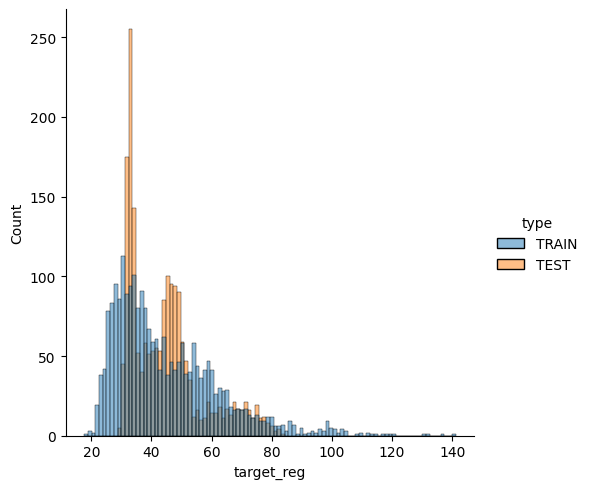

In [ ]:
# Посмотрим на то как распределилось наше предсказание относительно обучающих данных

tmp_df_1 = train['target_reg'].to_frame(name = 'target_reg')
tmp_df_1['type'] = 'TRAIN'
tmp_df_2 = tmp_sub['target_reg'].to_frame(name = 'target_reg')
tmp_df_2['type'] = 'TEST'
tmp_df_3 = pd.concat([tmp_df_1, tmp_df_2])
g = sns.displot(
  data=tmp_df_3,
  x='target_reg',
  hue="type",
  legend=True,
  aspect=1,
  kind="hist",
  alpha=0.5,
  bins= 100
);
del tmp_df_1, tmp_df_2, tmp_df_3

In [ ]:
tmp_sub[['car_id', 'target_reg']].to_csv('submission.csv', index=False)
print('CSV file saved!')

CSV file saved!


Итог:

Были выполнена все пункты.

Итоговый скор RMSE = 11.8.

Отдельно проверял нормализацию целевой переменной при помощи логорифмирования но оссобого эффекта не получил. Возможно необходимо больше опыта.

Итоговое предскозание довольно сильно смещенно влево в дальнейшем думаю стоит попробывать както сгладить этот перекос.
